In [1]:
from __future__ import division
import pickle
import os

import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rc('savefig', dpi=300)
# mpl.rc('text', usetex=True)

In [4]:
data_dir = os.path.join('data', 'lunarlander-sim')

Table 1, Figure 2

In [5]:
using_lander_reward_shaping = True

In [6]:
reward_logs = {}
rew_data_dir = os.path.join(data_dir, '12.12' if using_lander_reward_shaping else '12.22')
for f in os.listdir(rew_data_dir):
  if (not using_lander_reward_shaping and (f.endswith('-Y.pkl') or f.endswith('-N.pkl'))) or (using_lander_reward_shaping and (f.endswith('-Y.pkl') or f.endswith('-4.pkl') or f.endswith('-3.pkl') or f == 'noop-rawaction.pkl')):
    with open(os.path.join(rew_data_dir, f), 'rb') as f:
      reward_logs.update(pickle.load(f))

In [7]:
if using_lander_reward_shaping:
  reward_logs = {k: v for k, v in reward_logs.items() if not (('model' in k or 'super' in k) and 'using' not in k)}

In [8]:
def moving_avg(d, n=5):
    s = np.concatenate((np.zeros(1), np.cumsum(d).astype(float)))
    return (s[n:] - s[:-n]) / n

In [9]:
def make_nan_rew_mat(raw, max_ep_len=800):
  X = np.zeros((len(raw), min(max_ep_len, max(len(x) for x in raw))))
  X[:, :] = np.nan
  for i, x in enumerate(raw):
    x = x[:max_ep_len]
    X[i, :len(x)] = x
  return X

In [10]:
def make_nan_outcome_mat(raw, outcome, max_ep_len=800):
  X = np.zeros((len(raw), min(max_ep_len, max(len(x) for x in raw))))
  X[:, :] = np.nan
  for i, x in enumerate(raw):
    x = x[:max_ep_len]
    X[i, :len(x)] = [1 if z == outcome else 0 for z in x]
  return X

In [11]:
traj_col_means = lambda x: np.nanmean(x, axis=0)
traj_col_stderrs = lambda x: np.nanstd(x, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(x), axis=0))
r_mins = lambda x: traj_col_means(x) - traj_col_stderrs(x)
r_maxs = lambda x: traj_col_means(x) + traj_col_stderrs(x)

In [12]:
SUCCESS = 100
CRASH = -100

In [13]:
if using_lander_reward_shaping:
  pilot_evals_path = os.path.join(data_dir, '12.12', 'pilot_evals.pkl')
else:
  pilot_evals_path = os.path.join(data_dir, '12.22', 'pilot_evals.pkl')
with open(pilot_evals_path, 'rb') as f:
  pilot_evals = pickle.load(f)

In [14]:
def plot_config(R, prop_label, color, fill=True, smooth_win=20):
  if fill:
    x = range(R.shape[1] - (smooth_win - 1))
    y1 = moving_avg(r_mins(R), n=smooth_win)
    y2 = moving_avg(r_maxs(R), n=smooth_win)
    plt.fill_between(x, y1, y2, where=y2 >= y1, interpolate=True, facecolor=color, label=prop_label, alpha=0.5)
    plt.plot(moving_avg(traj_col_means(R), n=smooth_win), color)
  else:
    plt.plot(moving_avg(traj_col_means(R), n=smooth_win), color, label=prop_label)

In [15]:
normalize = lambda x: x / x.sum()

In [16]:
def outcome_rates(outcomes, outcome):
  outcomes = [[1 if x == outcome else 0 for x in y] for y in outcomes]
  return make_nan_rew_mat(outcomes)

In [17]:
def outcome_rate_of_pilot_eval(outcomes, outcome):
  return np.mean([1 if x == outcome else 0 for x in outcomes])

In [18]:
def outcome_stderr_of_pilot_eval(outcomes, outcome):
  d = [1 if x == outcome else 0 for x in outcomes]
  return np.std(d) / np.sqrt(len(d))

In [19]:
new_reward_logs = {}
for k, v in reward_logs.items():
  d = eval(k)
  tmp_using_lander_reward_shaping = d['using_lander_reward_shaping'] if 'using_lander_reward_shaping' in d else True
  new_k = (round(d['pilot_tol'], 2 if d['pilot_type'] == 'sensor' else 1), d['pilot_type'], d['embedding_type'], tmp_using_lander_reward_shaping)
  new_reward_logs[new_k] = v
reward_logs = new_reward_logs

In [20]:
pilot_names = ['full', 'laggy', 'noisy', 'noop', 'sensor']

In [21]:
for pilot_name in pilot_names:
  pilot_eval = pilot_evals[pilot_name]
  d = {
    'rewards': [[x]*100 for x in pilot_eval[0]],
    'outcomes': [[x]*100 for x in pilot_eval[1]]
  }
  for embedding_type in ['rawaction', 'modelbasedgoalinf', 'supervisedgoalinf']:
    for tmp_using_lander_reward_shaping in [True, False]:
      reward_logs[(1.0, pilot_name, embedding_type, tmp_using_lander_reward_shaping)] = d

In [22]:
new_reward_logs = {}
for config_name, config_data in reward_logs.items():
  d = {}
  for k, v in config_data.items():
    if k == 'rewards':
      d['rewards'] = make_nan_rew_mat(v)
    elif k == 'outcomes':
      d['success'] = make_nan_outcome_mat(v, SUCCESS)
      d['crash'] = make_nan_outcome_mat(v, CRASH)
  new_reward_logs[config_name] = d
reward_logs = new_reward_logs

In [23]:
alphas = [round(x, 1) for x in np.arange(0, 1.1, 0.1)]
sensor_alphas = [round(x, 2) for x in np.arange(0, 0.3, 0.03)]

In [24]:
def get_stats_without_copilot(pilot_name):
  pilot_eval = pilot_evals[pilot_name]
  R = pilot_eval[0]
  mean_rew = np.nanmean(R)
  stderr_rew = np.nanstd(R) / np.sqrt(np.count_nonzero(~np.isnan(R)))
  succ_rate = outcome_rate_of_pilot_eval(pilot_eval[1], outcome=SUCCESS)
  crash_rate = outcome_rate_of_pilot_eval(pilot_eval[1], outcome=CRASH)
  return int(mean_rew), int(stderr_rew), succ_rate, crash_rate

def summarize_reward_log(reward_log):
  R = reward_log['rewards']
  rews = moving_avg(traj_col_means(R), n=100)
  stderr_rews = moving_avg(traj_col_stderrs(R), n=100)
  succ_rates = moving_avg(traj_col_means(reward_log['success']), n=100)
  crash_rates = moving_avg(traj_col_means(reward_log['crash']), n=100)
  t = max(list(range(len(rews))), key=lambda i: rews[i])
  return int(rews[t]), int(stderr_rews[t]), succ_rates[t], crash_rates[t], (100+t)

def get_stats_with_copilot(pilot_name, embedding_type='rawaction', tmp_using_lander_reward_shaping=False):
  if pilot_name == 'noop':
    return summarize_reward_log(reward_logs[(0, pilot_name, embedding_type, tmp_using_lander_reward_shaping)]), 0
  else:
    my_alphas = sensor_alphas if pilot_name == 'sensor' and (embedding_type != 'rawaction' or not tmp_using_lander_reward_shaping) else alphas
    stats_for_all_alpha = [summarize_reward_log(reward_logs[(alpha, pilot_name, embedding_type, tmp_using_lander_reward_shaping)]) for alpha in my_alphas]
    return max(list(zip(stats_for_all_alpha, alphas)), key=lambda x: x[0][0])

In [25]:
def capitalize(x):
  return x[0].upper() + x[1:]

def format_pilot_name(x):
  return capitalize(x).replace('Full', 'Optimal').replace('Noop', 'None')

In [26]:
with open(os.path.join(data_dir, 'solo-vs-team-table%s.txt' % ('' if using_lander_reward_shaping else '-no-gds')), 'w') as f:
  for pilot_name in ['human', 'noop', 'sensor', 'laggy', 'noisy', 'full']:
    without_copilot_stats = get_stats_without_copilot(pilot_name)
    if pilot_name in ['human', 'full']:
      f.write('%s & $%d \pm %d$  &  %.3f  & %.3f  &  &  &  &  & \\\\\n' % (format_pilot_name(pilot_name),
        *without_copilot_stats))
    else:
      with_copilot_stats, best_alpha = get_stats_with_copilot(pilot_name, tmp_using_lander_reward_shaping=using_lander_reward_shaping)
      if pilot_name == 'noop':
        f.write('%s &  &  &  & $%d \pm %d$ & %.3f & %.3f & %d & %.1f \\\\\n' % (format_pilot_name(pilot_name),
        *with_copilot_stats, best_alpha))
      else:
        f.write('%s & $%d \pm %d$  &  %.3f  & %.3f  & $%d \pm %d$ & %.3f & %.3f & %d & %.1f \\\\\n' % (format_pilot_name(pilot_name),
          *without_copilot_stats, *with_copilot_stats, best_alpha))

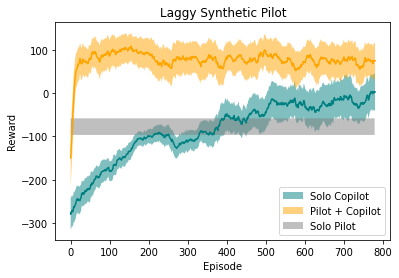

In [27]:
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Laggy Synthetic Pilot')

plot_config(reward_logs[(0, 'noop', 'rawaction', using_lander_reward_shaping)]['rewards'], 'Solo Copilot', 'teal')
plot_config(reward_logs[(0.7, 'laggy', 'rawaction', using_lander_reward_shaping)]['rewards'], r'Pilot + Copilot', 'orange')

R = pilot_evals['laggy'][0]
mean_rew = np.nanmean(R)
stderr_rew = np.nanstd(R) / np.sqrt(np.count_nonzero(~np.isnan(R)))
max_eps = 780
x = np.array(range(max_eps))
y1 = np.ones(max_eps) * (mean_rew - stderr_rew)
y2 = np.ones(max_eps) * (mean_rew + stderr_rew)
plt.fill_between(x, y1, y2, where=y2 >= y1, interpolate=True, facecolor='gray', label='Solo Pilot', alpha=0.5)

plt.legend(loc='lower right')
if not using_lander_reward_shaping:
  plt.xlim([0, 500])
plt.savefig(os.path.join(data_dir, 'laggy-pilot-solo-vs-team-reward%s.pdf' % ('' if using_lander_reward_shaping else '-no-gds')), bbox_inches='tight')
plt.show()

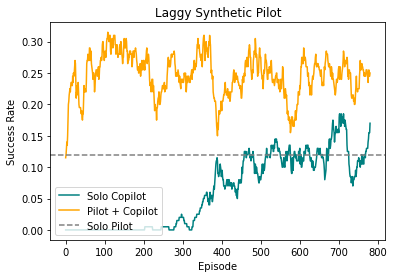

In [28]:
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Laggy Synthetic Pilot')

plot_config(reward_logs[(0, 'noop', 'rawaction', using_lander_reward_shaping)]['success'], 'Solo Copilot', 'teal', fill=False)
plot_config(reward_logs[(0.7, 'laggy', 'rawaction', using_lander_reward_shaping)]['success'], r'Pilot + Copilot', 'orange', fill=False)

R = pilot_evals['laggy'][1]
mean_rew = outcome_rate_of_pilot_eval(R, outcome=SUCCESS)
plt.axhline(y=mean_rew, linestyle='--', label='Solo Pilot', color='gray')

plt.legend(loc='lower left')
if not using_lander_reward_shaping:
  plt.xlim([0, 500])
plt.savefig(os.path.join(data_dir, 'laggy-pilot-solo-vs-team-success-rate%s.pdf' % ('' if using_lander_reward_shaping else '-no-gds')), bbox_inches='tight')
plt.show()

re-run the cells above with `using_lander_reward_shaping = True`, then run the cells below

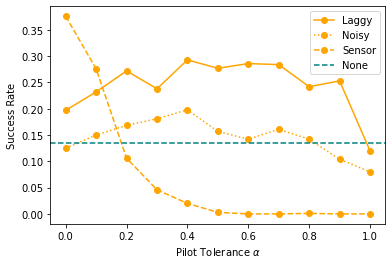

In [29]:
embedding_type = 'rawaction'
plt.xlabel(r'Pilot Tolerance $\alpha$')
plt.ylabel('Success Rate')
for pilot_type, linestyle, marker in [('laggy', '-', 'o'), ('noisy', ':', 'o'), ('sensor', '--', 'o')]:
  my_alphas = sensor_alphas if pilot_type == 'sensor' and not using_lander_reward_shaping else alphas
  mean_rews, stderr_rews, succ_rates, crash_rates, time_to_best_perfs = zip(*[summarize_reward_log(reward_logs[(alpha, pilot_type, embedding_type, using_lander_reward_shaping)]) for alpha in my_alphas])
  plt.plot(my_alphas, succ_rates, label=capitalize(pilot_type), color='orange', marker=marker, linestyle=linestyle)
plt.axhline(y=summarize_reward_log(reward_logs[(0, 'noop', 'rawaction', using_lander_reward_shaping)])[2], linestyle='--', color='teal', label='None')
plt.legend(loc='best')
plt.savefig(os.path.join(data_dir, 'pilot-vs-alpha-succ-rate%s.pdf' % ('' if using_lander_reward_shaping else '-no-gds')), bbox_inches='tight')
plt.show()

In [30]:
def format_embedding_name(x):
  if x == 'rawaction':
    return 'Raw Action Embedding'
  elif x == 'modelbasedgoalinf':
    return 'Bayesian Goal Inference'
  elif x == 'supervisedgoalinf':
    return 'Supervised Goal Prediction'
  else:
    raise ValueError

In [31]:
odd = lambda l: l[:1] + l[1::2] + l[-1:]

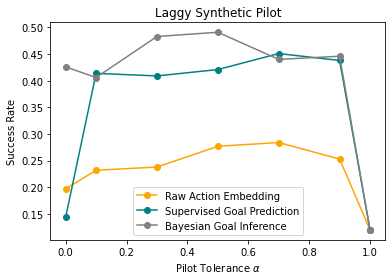

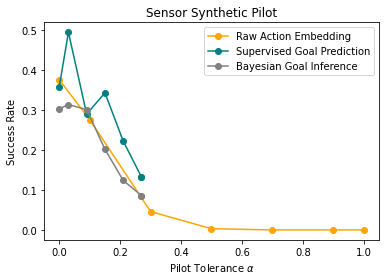

In [32]:
for pilot_type in ['laggy', 'sensor']:
  plt.title('%s Synthetic Pilot' % format_pilot_name(pilot_type))
  plt.xlabel(r'Pilot Tolerance $\alpha$')
  plt.ylabel('Success Rate')
  for embedding_type, color in [('rawaction', 'orange'), ('supervisedgoalinf', 'teal'), ('modelbasedgoalinf', 'gray')]:
    if pilot_type == 'sensor' and (embedding_type != 'rawaction' or not using_lander_reward_shaping):
      my_alphas = [round(float(x), 2) for x in np.arange(0, 0.3, 0.03)]
    else:
      my_alphas = alphas
    # something's wrong with the first config used at the beginning of each AWS script
    # so filter those out
    my_alphas = odd(my_alphas)
    mean_rews, stderr_rews, succ_rates, crash_rates, time_to_best_perfs = zip(*[summarize_reward_log(reward_logs[(alpha, pilot_type, embedding_type, using_lander_reward_shaping)]) for alpha in my_alphas])
    plt.plot(my_alphas, succ_rates, color=color, label=format_embedding_name(embedding_type), marker='o')
  plt.legend(loc='best')
  plt.savefig(os.path.join(data_dir, '%s-pilot-embedding-vs-alpha%s.pdf' % (pilot_type, '' if using_lander_reward_shaping else '-no-gds')), bbox_inches='tight')
  plt.show()

Table 2

In [33]:
with open(os.path.join(data_dir, 'cross_evals.pkl'), 'rb') as f:
  cross_evals = pickle.load(f)

In [34]:
pilot_ids = ['noop', 'sensor', 'laggy', 'noisy']
pilot_names = ['None', 'Sensor', 'Laggy', 'Noisy']

In [35]:
cross_eval_rew = np.zeros((len(pilot_ids), len(pilot_ids)))
cross_eval_succ = np.zeros((len(pilot_ids), len(pilot_ids)))
cross_eval_crash = np.zeros((len(pilot_ids), len(pilot_ids)))
for i, train_pilot_id in enumerate(pilot_ids):
  for j, eval_pilot_id in enumerate(pilot_ids):
    rewards, outcomes = list(zip(*cross_evals[(train_pilot_id, eval_pilot_id)]))
    succ_rate = np.mean([1 if x == 100 else 0 for x in outcomes])
    crash_rate = np.mean([1 if x == -100 else 0 for x in outcomes])
    mean_rew = np.mean(rewards)
    cross_eval_rew[i, j] = mean_rew
    cross_eval_succ[i, j] = succ_rate
    cross_eval_crash[i, j] = crash_rate

In [36]:
for i, pilot_name in enumerate(pilot_names):
  print('%s & %d & %d & %d & %d \\\\' % (pilot_name, *list(cross_eval_rew[i].astype(int))))

None & -98 & -199 & 33 & -79 \\
Sensor & 11 & 92 & 52 & -16 \\
Laggy & -114 & -72 & 75 & 33 \\
Noisy & -32 & -40 & 62 & 5 \\


In [37]:
for i, pilot_name in enumerate(pilot_names):
  print('%s & %0.2f & %0.2f & %0.2f & %0.2f \\\\' % (pilot_name, *list(cross_eval_succ[i])))

None & 0.02 & 0.02 & 0.29 & 0.04 \\
Sensor & 0.18 & 0.46 & 0.31 & 0.23 \\
Laggy & 0.00 & 0.00 & 0.31 & 0.23 \\
Noisy & 0.10 & 0.10 & 0.38 & 0.21 \\


In [38]:
for i, pilot_name in enumerate(pilot_names):
  print('%s & %0.2f & %0.2f & %0.2f & %0.2f \\\\' % (pilot_name, *list(cross_eval_crash[i])))

None & 0.03 & 0.75 & 0.11 & 0.14 \\
Sensor & 0.45 & 0.31 & 0.16 & 0.16 \\
Laggy & 1.00 & 0.83 & 0.12 & 0.32 \\
Noisy & 0.40 & 0.55 & 0.13 & 0.21 \\


In [39]:
interleave = lambda x, y: sum(map(list, list(zip(x, y))), [])

In [40]:
for i, pilot_name in enumerate(pilot_names):
  print(('%s & %0.2f / %0.2f & %0.2f / %0.2f & %0.2f / %0.2f & %0.2f / %0.2f \\\\' % (pilot_name, *interleave(list(cross_eval_succ[i]), list(cross_eval_crash[i])))).replace('0.', '.'))

None & .02 / .03 & .02 / .75 & .29 / .11 & .04 / .14 \\
Sensor & .18 / .45 & .46 / .31 & .31 / .16 & .23 / .16 \\
Laggy & .00 / 1.00 & .00 / .83 & .31 / .12 & .23 / .32 \\
Noisy & .10 / .40 & .10 / .55 & .38 / .13 & .21 / .21 \\
